source: https://sofifa.com/

# Imports

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import re

# Data loading and pre-processing

## Data cleaning

In [13]:
df = pd.read_csv('Fifa2022-Males.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 104 entries, sofifa_id to gk
dtypes: float64(18), int64(44), object(42)
memory usage: 15.3+ MB


In [14]:
df.columns.tolist()

['sofifa_id',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'moveme

In [15]:
df = df.drop(columns=[
    'sofifa_id',
    'long_name',
    'dob',  # date of birth
    'club_team_id',
    'club_position',
    'club_jersey_number',
    'club_loaned_from',
    'club_joined',
    'club_contract_valid_until',
    'nationality_id',
    'nation_team_id',
    'nation_position',
    'nation_jersey_number',
    'work_rate',
    'body_type',
    'real_face',
    'player_tags',
    'player_traits'
]);

In [16]:
def nan_columns(df: DataFrame, head: int = 10):  # columns with quantities of NA descending
    print(df.isna().sum().sort_values(ascending=False).head(head))

In [17]:
nan_columns(df, head=18)

goalkeeping_speed     17107
pace                   2132
shooting               2132
passing                2132
dribbling              2132
defending              2132
physic                 2132
release_clause_eur     1176
rw                      326
lw                      326
value_eur                74
league_name              61
league_level             61
wage_eur                 61
club_name                61
rs                        0
lf                        0
cf                        0
dtype: int64


In [18]:
df = df.dropna(subset=['value_eur'])  # no data about value
df = df.drop(columns=['pace', 'defending', 'dribbling', 'passing', 'shooting', 'physic',
                      'goalkeeping_speed'])  # incompatible data (from 2 different versions, complementary nan's)])  
df['release_clause_eur'] = df['release_clause_eur'].fillna(0)  # probably no release clause
df['lw'] = df['lw'].fillna(df['lf'])  # position lw is closest to lf
df['rw'] = df['rw'].fillna(df['rf'])  # position rw is closest to rf

# TODO zmapować 'players_positions' do 'players_position' (jednej z czterech)

In [19]:
nan_columns(df, head=3)

short_name                 0
goalkeeping_positioning    0
cf                         0
dtype: int64


In [20]:
cols_dict = {
    'descriptive': ['short_name',
                    'player_positions',  # TODO podmienić na players_position jak będzie gotowe
                    'club_name',
                    'league_name',
                    'nationality_name',
                    'preferred_foot'],
    'score': ['overall',
              'potential'],
    'attacking': ['attacking_crossing',
                  'attacking_finishing',
                  'attacking_heading_accuracy',
                  'attacking_short_passing',
                  'attacking_volleys'],
    'skill': ['skill_dribbling',
              'skill_curve',
              'skill_fk_accuracy',
              'skill_long_passing',
              'skill_ball_control'],
    'movement': ['movement_acceleration',
                 'movement_sprint_speed',
                 'movement_agility',
                 'movement_reactions',
                 'movement_balance'],
    'power': ['power_shot_power',
              'power_jumping',
              'power_stamina',
              'power_strength',
              'power_long_shots'],
    'mentality': ['mentality_aggression',
                  'mentality_interceptions',
                  'mentality_positioning',
                  'mentality_vision',
                  'mentality_penalties',
                  'mentality_composure'],
    'defending': ['defending_marking_awareness',
                  'defending_standing_tackle',
                  'defending_sliding_tackle'],
    'goalkeeping': ['goalkeeping_diving',
                    'goalkeeping_handling',
                    'goalkeeping_kicking',
                    'goalkeeping_positioning',
                    'goalkeeping_reflexes'],
    'position': [      'ls' ,'st' ,'rs',
                 'lw' ,'lf' ,'cf' ,'rf', 'rw',
                       'lam','cam','ram',
                 'lm' ,'lcm','cm' ,'rcm', 'rm',  # arrangement of positions
                 'lwb','ldm','cdm','rdm','rwb',
                 'lb', 'lcb','cb' ,'rcb', 'rb',
                             'gk']
}
cols_dict['features'] = [cols_dict[feature] for feature in cols_dict.keys()]
cols_dict['features'] = sum(cols_dict['features'], [])  # flaten list of lists
cols_dict['all'] = df.columns.to_list()
columns = cols_dict['all']
cols_dict['others'] = list(set(cols_dict['all']) - set(cols_dict['features']))
cols_dict['others'].sort()
cols_dict['others']

['age',
 'height_cm',
 'international_reputation',
 'league_level',
 'release_clause_eur',
 'skill_moves',
 'value_eur',
 'wage_eur',
 'weak_foot',
 'weight_kg']

In [21]:
df[cols_dict['position']] = df[cols_dict['position']].map(
    lambda datum: sum([int(x) for x in re.split(r'[+-]', datum)]) if isinstance(datum, str) 
    else int(datum))  # including +- for 'international_reputation'

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   short_name                   19165 non-null  object 
 1   player_positions             19165 non-null  object 
 2   overall                      19165 non-null  int64  
 3   potential                    19165 non-null  int64  
 4   value_eur                    19165 non-null  float64
 5   wage_eur                     19165 non-null  float64
 6   age                          19165 non-null  int64  
 7   height_cm                    19165 non-null  int64  
 8   weight_kg                    19165 non-null  int64  
 9   club_name                    19165 non-null  object 
 10  league_name                  19165 non-null  object 
 11  league_level                 19165 non-null  float64
 12  nationality_name             19165 non-null  object 
 13  preferred_foot       

## Visualization cleaned data

In [23]:
df[cols_dict['descriptive']].describe()[1:]

,short_name,player_positions,club_name,league_name,nationality_name,preferred_foot
unique,18076,674,701,55,163,2
top,J. Rodríguez,CB,Paris Saint-Germain,USA Major League Soccer,England,Right
freq,13,2408,33,771,1717,14616


In [24]:
df[cols_dict['others']].describe()[1:]

,age,height_cm,international_reputation,league_level,release_clause_eur,skill_moves,value_eur,wage_eur,weak_foot,weight_kg
mean,25.190034,181.290008,1.093817,1.354239,5.065033e+06,2.351944,2.850452e+06,9021.721889,2.945682,74.930342
std,4.727515,6.862654,0.370406,0.747572,1.456604e+07,0.767516,7.613700e+06,19476.005074,0.671623,7.066639
min,16.000000,155.000000,1.000000,1.000000,0.000000e+00,1.000000,9.000000e+03,500.000000,1.000000,49.000000
25%,21.000000,176.000000,1.000000,1.000000,6.980000e+05,2.000000,4.750000e+05,1000.000000,3.000000,70.000000
50%,25.000000,181.000000,1.000000,1.000000,1.500000e+06,2.000000,9.750000e+05,3000.000000,3.000000,75.000000
75%,29.000000,186.000000,1.000000,1.000000,3.500000e+06,3.000000,2.000000e+06,8000.000000,3.000000,80.000000
max,43.000000,206.000000,5.000000,5.000000,3.735000e+08,5.000000,1.940000e+08,350000.000000,5.000000,110.000000


In [25]:
def show_boxplot(df: DataFrame, columns: str):
    if columns in cols_dict.keys():
        labels = cols_dict[columns]
        labels = [label.removeprefix(columns + '_') for label in labels]
    else:
        labels = None
    
    leftmargin = 0.5
    rightmargin = 0.3
    categorysize = 0.1

    n = df.shape[1]

    figwidth = leftmargin + rightmargin + (n+1)*categorysize

    fig, ax = plt.subplots(figsize=(figwidth, 6))
    fig.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth,
                        top=0.94, bottom=0.1)
    ax.boxplot(df[cols_dict[columns]], labels=labels)
    plt.title(columns)
    plt.show()

dict_keys(['descriptive', 'score', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping', 'position', 'features', 'all', 'others'])


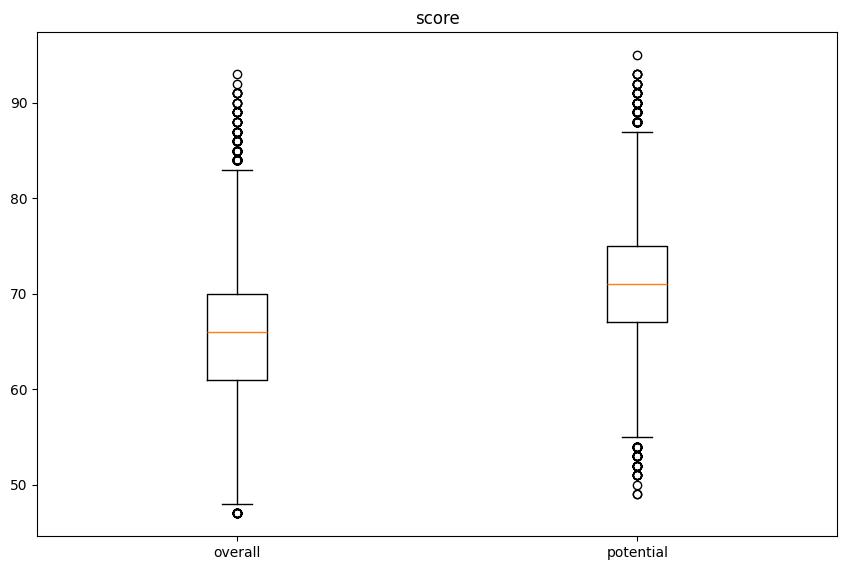

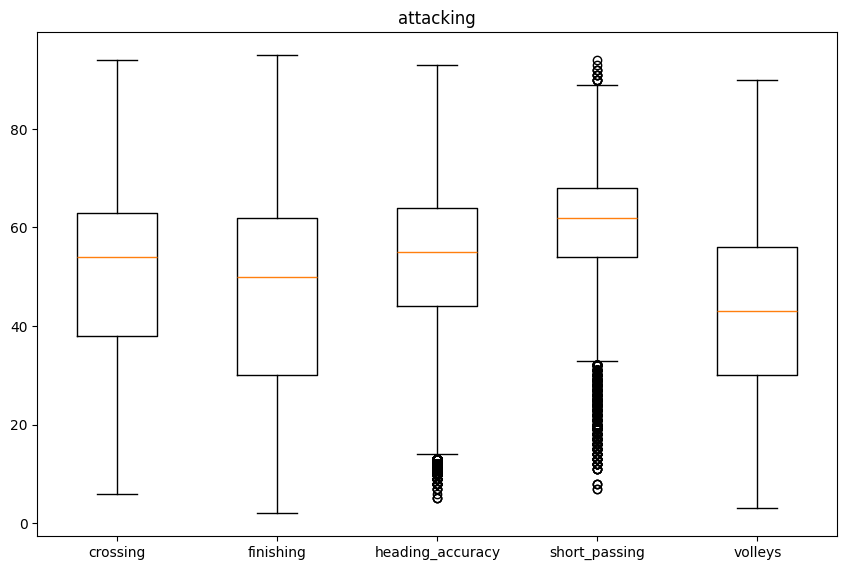

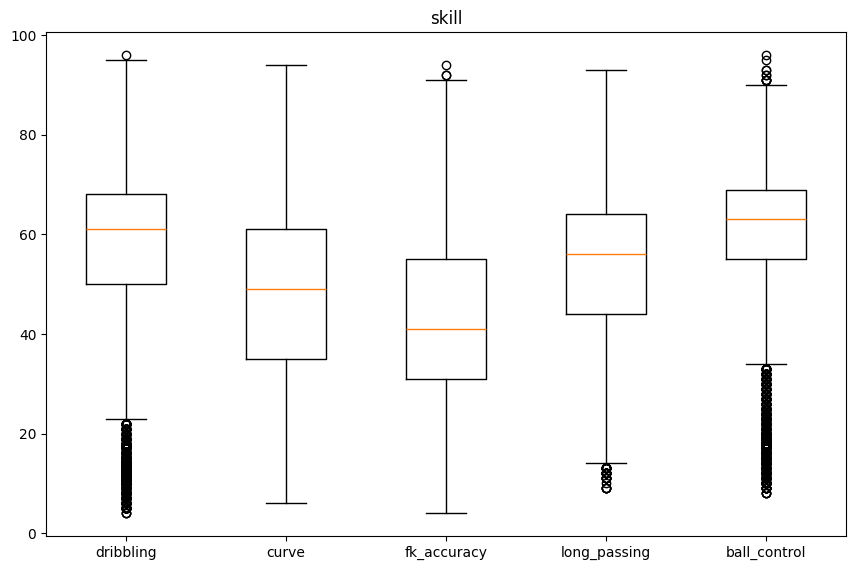

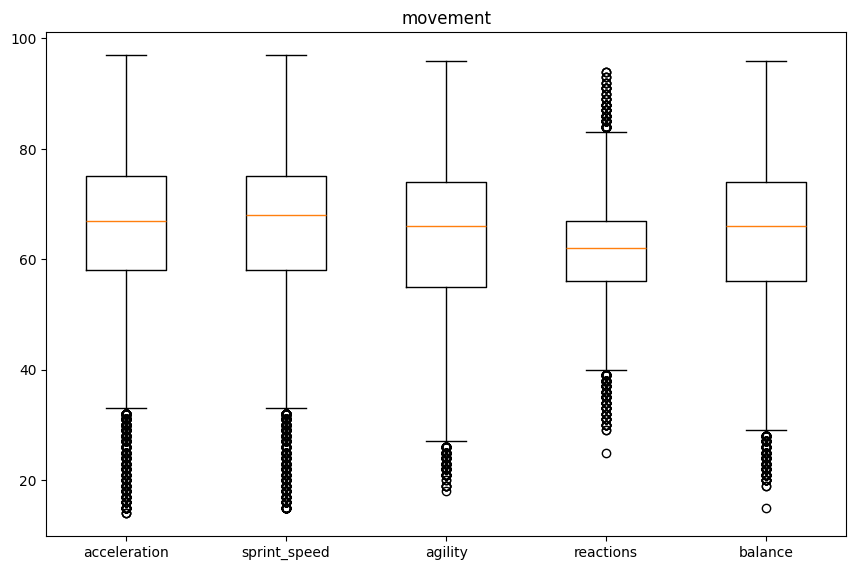

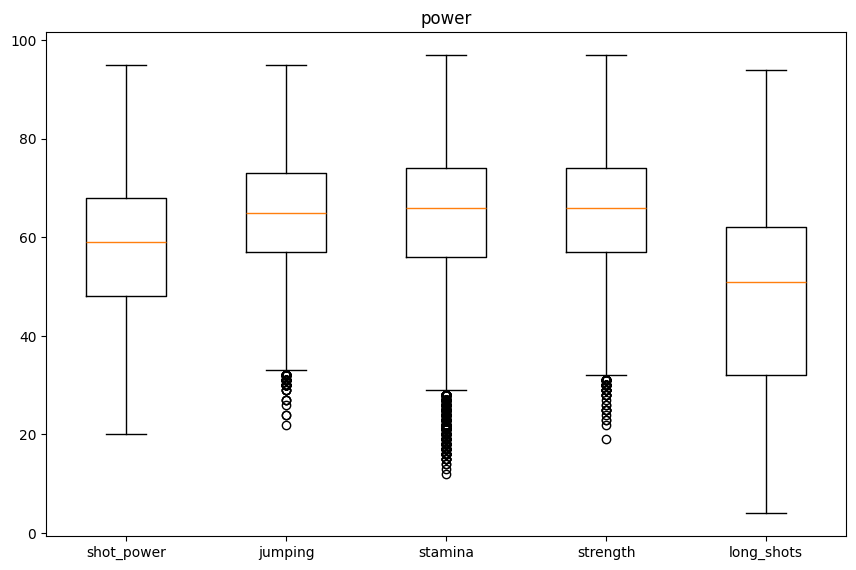

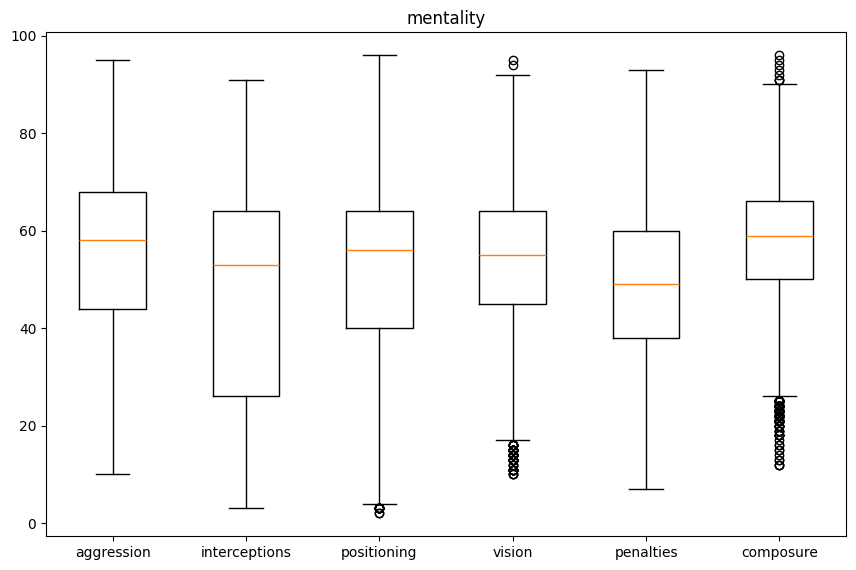

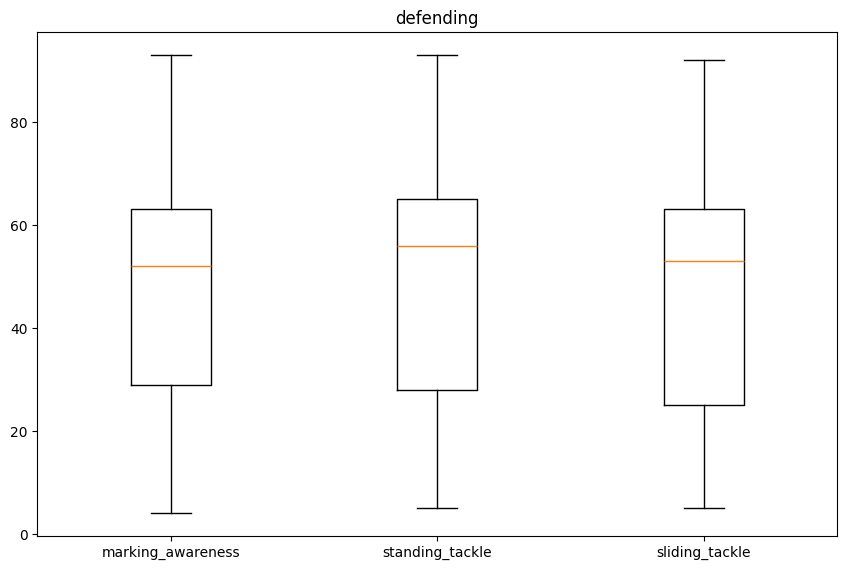

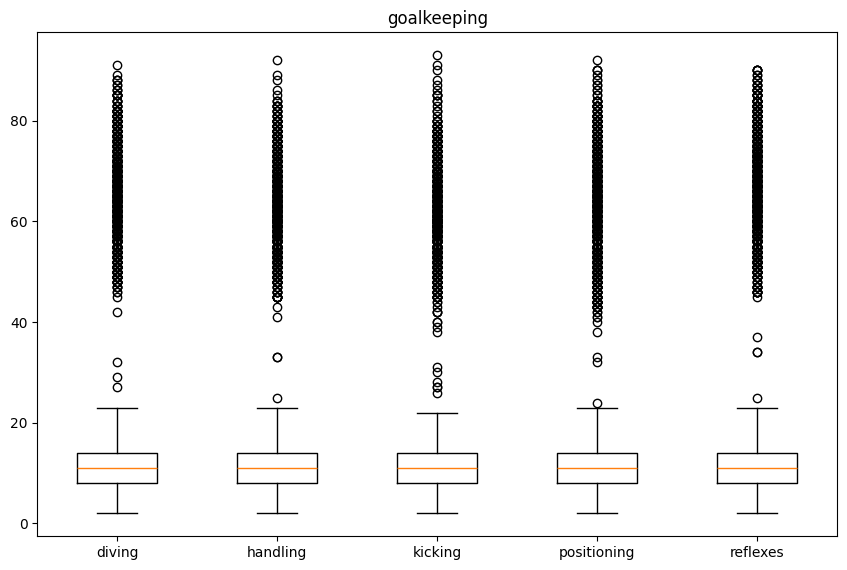

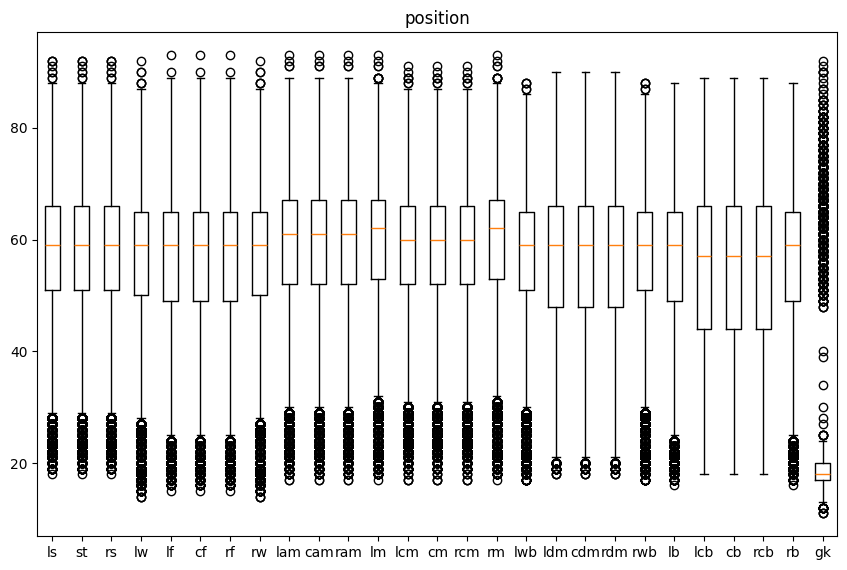

In [26]:
print(cols_dict.keys())
for key in cols_dict.keys():
    if key not in ['descriptive', 'features', 'all', 'others']:
        show_boxplot(df, key)

# Standaryzacja

In [29]:
from sklearn.preprocessing import StandardScaler

In [27]:
df_stand = df.copy()

col_drop_standard = [
    'short_name',
    'player_positions',
    'club_name',
    'league_name',
    'nationality_name',
    'preferred_foot'
]
df_stand =  df_stand.drop(columns = col_drop_standard)

df_stand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19165 non-null  int64  
 1   potential                    19165 non-null  int64  
 2   value_eur                    19165 non-null  float64
 3   wage_eur                     19165 non-null  float64
 4   age                          19165 non-null  int64  
 5   height_cm                    19165 non-null  int64  
 6   weight_kg                    19165 non-null  int64  
 7   league_level                 19165 non-null  float64
 8   weak_foot                    19165 non-null  int64  
 9   skill_moves                  19165 non-null  int64  
 10  international_reputation     19165 non-null  int64  
 11  release_clause_eur           19165 non-null  float64
 12  attacking_crossing           19165 non-null  int64  
 13  attacking_finishing  

In [30]:
scaler = StandardScaler()
data_1 = df_stand.iloc[:,:]
data_stand = scaler.fit_transform(data_1)
data_stand

array([[ 3.95776568,  3.60078658,  9.87056351, ..., -0.09175446,
         0.60450243, -0.08375154],
       [ 3.81247225,  3.4365172 , 15.32140647, ...,  0.58798046,
         0.60450243, -0.08375154],
       [ 3.66717883,  3.27224782,  5.53615826, ...,  0.11216602,
         0.53345973, -0.01738129],
       ...,
       [-2.725732  , -2.64144996, -0.36125978, ..., -0.49959541,
        -0.46113814, -0.61471362],
       [-2.725732  , -1.82010304, -0.35994632, ..., -1.79109176,
        -1.52677872, -0.41560284],
       [-2.725732  , -1.82010304, -0.35994632, ..., -0.77148938,
        -0.60322355, -0.34923258]])

# Wyznaczanie składowych głównych

In [31]:
from sklearn.decomposition import PCA

In [32]:
index_pca = [
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation', 
 'release_clause_eur',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',  
 'goalkeeping_diving',
 'goalkeeping_handling', 
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm', 
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm' ,
 'rwb', 
 'lb',
 'lcb', 
 'cb',
 'rcb',
 'rb',
 'gk'
]

In [33]:
pca = PCA()
pca_data = pca.fit_transform(data_stand)
n_components = len(pca.components_)
pca_cols = [f'PC{x+1}' for x in range(n_components)]
df_pca_componenets = pd.DataFrame(data=np.transpose(pca.components_), columns=pca_cols, index = index_pca)
df_pca_componenets

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
overall,-0.075277,0.014412,0.321880,0.022718,-0.093655,-0.147561,-0.155440,-0.029210,-0.016854,0.007792,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00
potential,-0.051766,-0.014853,0.210185,0.185720,0.196446,0.019810,-0.529886,0.060302,0.066958,-0.277811,...,-3.599632e-17,-4.470975e-17,3.780343e-17,4.395126e-17,-2.800580e-17,2.322328e-17,3.157155e-17,3.246390e-17,-3.998149e-17,2.103903e-17
value_eur,-0.046076,-0.013194,0.275767,0.213659,0.334706,0.055860,0.181529,0.022111,-0.031531,0.055012,...,1.133686e-16,1.555243e-17,1.122525e-16,3.051974e-17,8.644664e-17,1.395173e-17,5.751484e-17,1.287557e-16,-1.168498e-16,-1.898908e-17
wage_eur,-0.049716,-0.006123,0.285284,0.165034,0.256075,0.046334,0.216481,-0.008100,-0.027127,0.035363,...,3.805963e-17,3.476780e-17,-1.470802e-16,-1.557178e-16,-4.319045e-17,1.545397e-17,-2.235588e-17,-1.319806e-16,1.482792e-16,-7.417425e-17
age,-0.021237,0.039284,0.177595,-0.195352,-0.371371,-0.165567,0.452907,-0.131315,-0.069019,0.225699,...,-1.010257e-16,-1.361857e-16,2.183716e-17,1.487110e-17,-2.274165e-17,-3.520666e-17,-3.749808e-17,4.549791e-18,6.907960e-19,2.501994e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lcb,-0.111225,0.225916,0.007528,-0.000280,-0.008247,-0.006898,-0.003593,-0.000286,0.009168,-0.019413,...,-1.844244e-01,1.602200e-01,2.049891e-01,2.249510e-01,3.305097e-01,4.379244e-01,-1.754754e-01,-1.060948e-01,-2.168055e-02,-1.986279e-01
cb,-0.111225,0.225916,0.007528,-0.000280,-0.008247,-0.006898,-0.003593,-0.000286,0.009168,-0.019413,...,-4.842028e-02,-1.561621e-03,-3.383488e-01,-3.456923e-01,-2.455537e-01,-2.689090e-01,2.275591e-01,2.916591e-01,-6.473629e-02,1.931773e-01
rcb,-0.111225,0.225916,0.007528,-0.000280,-0.008247,-0.006898,-0.003593,-0.000286,0.009168,-0.019413,...,2.328447e-01,-1.586584e-01,1.333597e-01,1.207413e-01,-8.495601e-02,-1.690153e-01,-5.208364e-02,-1.855643e-01,8.641684e-02,5.450557e-03
rb,-0.131271,0.161819,-0.016766,0.067482,-0.026352,-0.022092,-0.017063,0.011507,-0.007168,0.059351,...,4.268316e-01,5.112389e-02,4.731106e-02,8.978325e-02,-1.812160e-01,6.734231e-02,1.434644e-02,-1.671486e-02,1.011349e-02,5.459507e-04


# Kryterium wartości własnej

In [34]:
print(pca_cols[:10])
print(pca.explained_variance_[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[42.85175608  9.07670078  5.74092609  2.74351085  1.98767088  1.30189931
  1.11639744  0.97848215  0.83717871  0.66907079]


# Kryterium częsci wyjaśnionej wariancji

In [35]:
print(pca_cols[:10])
print(np.cumsum(pca.explained_variance_ratio_)[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[0.58697973 0.71131161 0.78995033 0.82753071 0.85475765 0.87259096
 0.88788328 0.90128644 0.91275405 0.92191892]


# Kryterium minimalnego zasobu zmienności

In [36]:
pd.set_option('display.max_rows', None) # wyświetlanie wszyskich wierszów
pcaS = df_pca_componenets.pow(2).cumsum(axis=1)
pcaS

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
overall,0.005667,0.005874,0.109481,0.109997,0.118768,0.140543,0.164704,0.165557,0.165841,0.165902,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
potential,0.002680,0.002900,0.047078,0.081570,0.120161,0.120554,0.401333,0.404969,0.409452,0.486631,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
value_eur,0.002123,0.002297,0.078345,0.123995,0.236023,0.239144,0.272096,0.272585,0.273579,0.276606,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
wage_eur,0.002472,0.002509,0.083896,0.111132,0.176706,0.178853,0.225717,0.225783,0.226519,0.227769,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
age,0.000451,0.001994,0.033534,0.071697,0.209613,0.237026,0.442151,0.459394,0.464158,0.515098,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
height_cm,0.003873,0.015552,0.040188,0.142598,0.171880,0.180404,0.213013,0.234484,0.234618,0.272171,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
weight_kg,0.002396,0.011763,0.045949,0.168096,0.178630,0.178834,0.190220,0.195665,0.196377,0.281940,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
league_level,0.000111,0.000117,0.005199,0.008707,0.009315,0.035042,0.067868,0.932876,0.947568,0.968833,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
weak_foot,0.002800,0.007512,0.009293,0.009726,0.010097,0.011599,0.015375,0.031010,0.973840,0.989825,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
skill_moves,0.013766,0.025215,0.025215,0.025536,0.025706,0.026084,0.026704,0.026707,0.027556,0.035672,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


# Analiza czynnikowa

In [1]:
pip install factor_analyzer

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 KB 881.9 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 KB 4.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 5.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 KB 6.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42509 sha256=0c8ab63ef86ee298a8ca5c69c40c0157dfe713a4b1b0b9c435d1226dea0646a

In [37]:
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Wyliczenie współczynników FA

In [43]:
fa = FactorAnalysis(random_state=1)
data_transformed = fa.fit_transform(data_stand)
n_components = len(fa.components_)
fa_cols = [f'F{x+1}' for x in range(n_components)]
df_fa_componenets = pd.DataFrame(data=np.transpose(fa.components_), columns=fa_cols, index = index_pca)
df_fa_componenets

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F64,F65,F66,F67,F68,F69,F70,F71,F72,F73
overall,-0.503922,0.039257,0.714645,0.173639,0.226849,0.079552,-0.123244,-0.058073,0.097697,-0.133256,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0
potential,-0.347133,-0.030292,0.429765,0.002072,0.184085,0.362190,-0.197249,0.198777,-0.197337,-0.375493,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
value_eur,-0.295934,-0.025788,0.444482,0.072825,0.245066,0.718834,0.167356,-0.011193,-0.003877,0.078970,...,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
wage_eur,-0.320271,-0.009199,0.473511,0.113376,0.216309,0.588447,0.149451,-0.052008,0.032201,0.059313,...,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
age,-0.140537,0.094522,0.423383,0.249265,0.006958,-0.320243,0.114357,-0.289179,0.364376,0.248363,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
height_cm,0.400752,0.219638,0.187604,0.558787,0.002878,0.062792,-0.260018,-0.231100,-0.262343,0.031456,...,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
weight_kg,0.313897,0.185520,0.252008,0.576197,0.035589,-0.004352,-0.241705,-0.277582,-0.156575,0.102390,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
league_level,0.070251,0.001124,-0.137854,-0.008266,-0.000693,-0.066428,-0.010065,-0.015494,0.002235,0.105404,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
weak_foot,-0.342765,-0.178700,0.073490,0.020208,-0.016516,0.019377,0.017294,-0.017686,0.072673,-0.014887,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
skill_moves,-0.764598,-0.281317,-0.037048,-0.066071,0.020772,0.052958,0.063723,-0.072633,0.048138,-0.043975,...,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0


# Rotacja varimax

In [44]:
fav = FactorAnalysis(random_state=1, rotation = 'varimax')
data_transformed = fav.fit_transform(data_stand)
n_components = len(fav.components_)
fav_cols = [f'F{x+1}' for x in range(n_components)]
df_fav_componenets = pd.DataFrame(data=np.transpose(fav.components_), columns=fav_cols, index = index_pca)
df_fav_componenets

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F64,F65,F66,F67,F68,F69,F70,F71,F72,F73
overall,-0.415124,0.296229,0.561418,0.207286,0.029889,0.446044,-0.013801,-0.038634,0.113921,0.027121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
potential,-0.276732,0.153416,0.293668,0.045513,0.040988,0.456425,-0.003979,-0.017996,0.049135,-0.554581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
value_eur,-0.194026,0.102077,0.064712,0.024000,0.023208,0.920468,0.003273,0.009643,-0.002993,-0.052314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wage_eur,-0.223843,0.133301,0.127994,0.060391,-0.008464,0.820789,-0.002024,-0.020906,0.021035,0.026172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,-0.126683,0.156224,0.378824,0.205959,-0.108487,0.024101,0.012603,-0.014401,0.099052,0.692147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
height_cm,0.394515,-0.047898,0.079399,0.771168,-0.080982,0.075355,0.003725,0.013957,-0.059668,-0.060306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight_kg,0.298029,-0.030978,0.143372,0.776301,-0.049468,0.082089,0.016346,-0.003086,-0.010336,0.081130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
league_level,0.054487,-0.037460,-0.093322,0.033023,0.059468,-0.113271,0.022980,0.012051,0.031416,0.020048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weak_foot,-0.382812,0.025018,0.023070,-0.015757,0.011355,0.080944,0.062944,0.022504,0.055021,0.017046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
skill_moves,-0.777330,0.158440,-0.104210,-0.119682,0.087406,0.110944,0.120594,-0.018759,-0.040663,0.007669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
